In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [19]:
# Import images from folder as numpy arrays

img_arrays = []

filenames = sorted(os.listdir("CroppedYalePNG"))

for filename in filenames:
    img_path = os.path.join("CroppedYalePNG", filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # if statement to ensure all images exists and are of same shape
    if img is not None and img.shape == (192, 168):
        flatten_img = img.flatten()
        img_arrays.append(flatten_img)

In [20]:
# Extract one image for testing later, and leave rest for PCA

train_images = img_arrays[1:]
test_image = img_arrays[0]

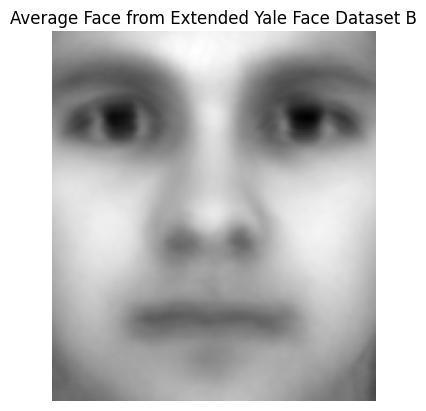

In [21]:
# Calculate the average of all the faces and plot

average_face = np.average(train_images, axis=0)

plt.imshow(np.reshape(average_face, (192, 168)), cmap="gray")
plt.title("Average Face from Extended Yale Face Dataset B")
plt.axis(False)
plt.show()

In [22]:
# Calculate mean subtracted matrix, X

tiled_average_face = np.tile(average_face, (len(train_images),1))
X = train_images - tiled_average_face

In [23]:
# Perform SVD to calculate the eigenvectors of X

U, S, V = np.linalg.svd(X, full_matrices=False)

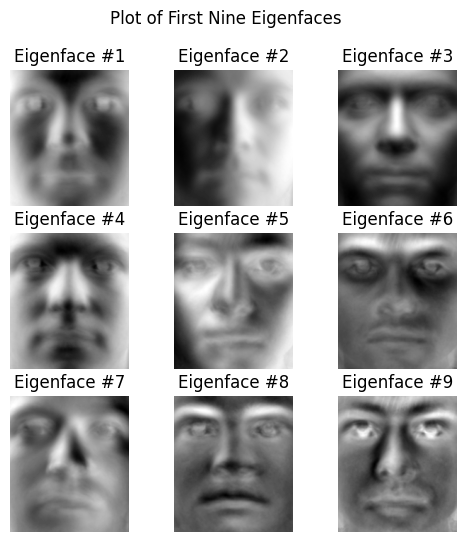

In [24]:
# Extract first 9 eigenfaces from V matrix and plot

fig = plt.figure(figsize=(6,6))
fig.suptitle("Plot of First Nine Eigenfaces")
for i in range(9):
    fig.add_subplot(3, 3, i+1)
    plt.imshow(np.reshape(V[i], (192, 168)), cmap="gray")
    plt.title(f"Eigenface #{i+1}")
    plt.axis(False)


We see that unsurprisingly, they generally take the shape of a face, with each different eigenface seeming to have an emphasis on specific parts of the face such as the forehead, mouth, nose, etc. Out of curiosity, we can also try to visualize some of the later eigenfaces and see why they are considered less significant.

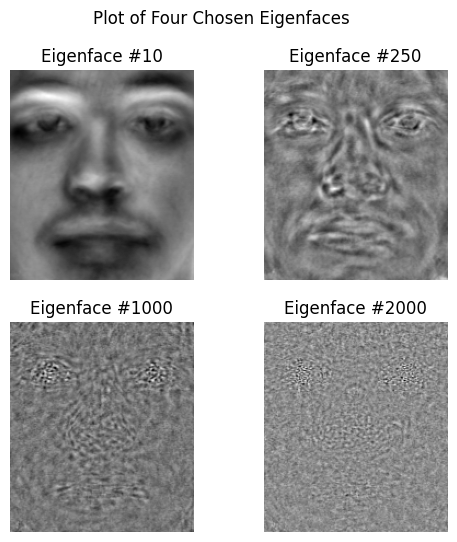

In [25]:
eigenface_values = [10, 250, 1000, 2000]

fig = plt.figure(figsize=(6,6))
fig.suptitle(f"Plot of Four Chosen Eigenfaces")

for i, eigenface_value in enumerate(eigenface_values):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(np.reshape(V[eigenface_value], (192, 168)), cmap="gray")
    plt.title(f"Eigenface #{eigenface_value}")
    plt.axis(False)


As expected, the later eigenfaces gradually begin to fail to resemble faces, turning into almost complete noise with only hints of disturbances around the prominent facial features such as the eyes, nose, and mouth. 

With our eigenfaces computed, we can now return to the test face that we had saved and attempt to recreate it with only a given number of our eigenfaces as done below. 

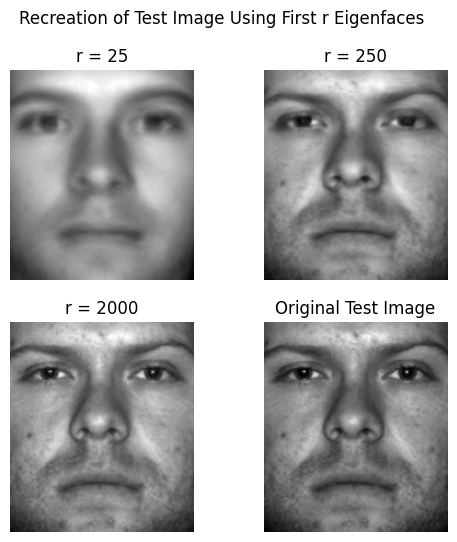

In [26]:
r_values = [25, 250, 2000]

test_image_subtracted = test_image - average_face

fig = plt.figure(figsize=(6,6))
fig.suptitle("Recreation of Test Image Using First r Eigenfaces")

for i, r in enumerate(r_values):
    fig.add_subplot(2, 2, i+1)
    recovered_image = average_face + V[:r,:].T @ V[:r,:] @ test_image_subtracted
    plt.imshow(np.reshape(recovered_image, (192, 168)), cmap="gray")
    plt.title(f"r = {r}")
    plt.axis(False)

fig.add_subplot(2, 2, 4)
plt.imshow(np.reshape(test_image, (192, 168)), cmap="gray")
plt.title(f"Original Test Image")
plt.axis(False)
plt.show()

We see that our eigenface decomposition manages to create a fairly decent approximation for the test face even with only a small portion of the eigenfaces. At just r = 250, the recovered image already looks very similar to the original, with only slight blurs while at r = 2000 it is nearly identical. This is of course unsurprising given that although this exact image was not in the training data, very similar images of the same person was, so this makes us question whether this eigendecomposition would work on a completely unrelated face. This is done below

In [27]:
color_img = cv2.imread("sample_face.jpg")
test_image_2 = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY).flatten()

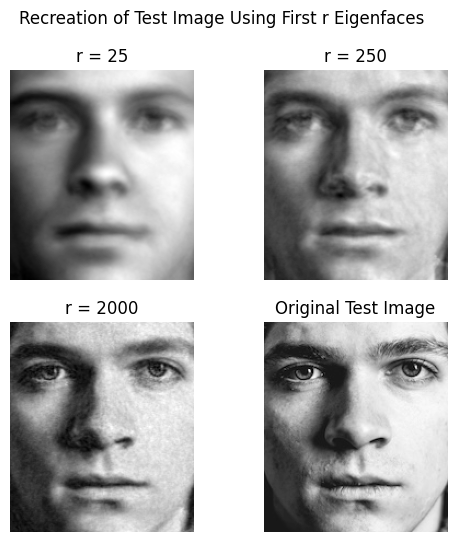

In [28]:
r_values = [25, 250, 2000]

test_image_subtracted_2 = test_image_2 - average_face

fig = plt.figure(figsize=(6,6))
fig.suptitle("Recreation of Test Image Using First r Eigenfaces")

for i, r in enumerate(r_values):
    fig.add_subplot(2, 2, i+1)
    recovered_image = average_face + V[:r,:].T @ V[:r,:] @ test_image_subtracted_2
    plt.imshow(np.reshape(recovered_image, (192, 168)), cmap="gray")
    plt.title(f"r = {r}")
    plt.axis(False)

fig.add_subplot(2, 2, 4)
plt.imshow(np.reshape(test_image_2, (192, 168)), cmap="gray")
plt.title(f"Original Test Image")
plt.axis(False)
plt.show()

As we had hoped, it still does a fairly decent job at recreating an image of a completely unrelated face, with it being already recognizable at r = 250. However, it definitely doesn't work as well as the previous example, with the image lacking a lot of detail and having a grainy pattern even at r = 2000. This is likely due to the fact that not only are images of this person not in the original data set, the conditions in which the photo was taken is almost certaintly very different from other photos. This is situation is sort of analogous to overtraining a neural network in machine learning. One way this could probably be avoided is if the data set had a much larger variety of people as well as varying conditions during photography (diffferent cameras, locations, etc).

Out of curiosity, we can also try to see what happens if we try to recreate a completely unrelated image that isn't even a face. This is done below.

In [29]:
color_img = cv2.imread("sample_image.jpg")
test_image_3 = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY).flatten()

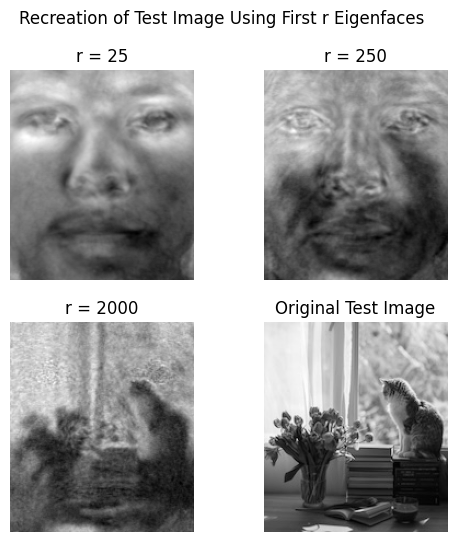

In [30]:
r_values = [25, 250, 2000]

test_image_subtracted_3 = test_image_3 - average_face

fig = plt.figure(figsize=(6,6))
fig.suptitle("Recreation of Test Image Using First r Eigenfaces")

for i, r in enumerate(r_values):
    fig.add_subplot(2, 2, i+1)
    recovered_image = average_face + V[:r,:].T @ V[:r,:] @ test_image_subtracted_3
    plt.imshow(np.reshape(recovered_image, (192, 168)), cmap="gray")
    plt.title(f"r = {r}")
    plt.axis(False)

fig.add_subplot(2, 2, 4)
plt.imshow(np.reshape(test_image_3, (192, 168)), cmap="gray")
plt.title(f"Original Test Image")
plt.axis(False)
plt.show()

Unsurprisingly, the eigenfaces really struggle to recreate this image for lower values of r since almost all of the higher ranked eigenfaces have the general structure of a face which is not at all suited for this specific image. We see that however, for r = 2000, since we gain access to many of the 'noisy' eigenfaces which allow to add more detail, the recreated image noticeably resembles the original image, albeit significantly blurred and grainy. 